<a href="https://colab.research.google.com/github/razranjan/Java_Coding/blob/master/Automatic_Ticket_Classification_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [ ]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
f = open('/content/drive/My Drive/NLP_Assignment/complaints-2021-05-14_08_16.json')


# returns JSON object as
# a dictionary
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [ ]:
# Inspect the dataframe to understand the given data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [ ]:
#print the column names
#print the column names
print("Columns are: ", df.columns.values)

Columns are:  ['_index' '_type' '_id' '_score' '_source.tags' '_source.zip_code'
 '_source.complaint_id' '_source.issue' '_source.date_received'
 '_source.state' '_source.consumer_disputed' '_source.product'
 '_source.company_response' '_source.company' '_source.submitted_via'
 '_source.date_sent_to_company' '_source.company_public_response'
 '_source.sub_product' '_source.timely' '_source.complaint_what_happened'
 '_source.sub_issue' '_source.consumer_consent_provided']


In [ ]:
#Assign new column names
df.rename(columns={'_index':'index',
  '_type':'type',
  '_id':'id',
  '_score':'score',
  '_source.tags':'tags',
  '_source.zip_code':'zip_code',
 '_source.complaint_id':'complaint_id',
 '_source.issue':'issue',
 '_source.date_received':'date_received',
 '_source.state':'state',
 '_source.consumer_disputed':'consumer_disputed',
 '_source.product':'product',
 '_source.company_response':'company_response',
 '_source.company':'company',
 '_source.submitted_via':'submitted_via',
 '_source.date_sent_to_company':'date_sent_to_company',
 '_source.company_public_response':'company_public_response',
 '_source.sub_product':'sub_product',
 '_source.timely':'timely',
 '_source.complaint_what_happened':'complaint_what_happened',
 '_source.sub_issue':'sub_issue',
 '_source.consumer_consent_provided':'consumer_consent_provided'},inplace=True)

In [ ]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].replace('', np.nan, inplace=True)

<ipython-input-21-d76549b330c8>:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [ ]:
#count null values after replacing blanks with nan
df['complaint_what_happened'].isnull().sum()

np.int64(57241)

In [ ]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'], inplace=True)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21072 entries, 1 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      21072 non-null  object 
 1   type                       21072 non-null  object 
 2   id                         21072 non-null  object 
 3   score                      21072 non-null  float64
 4   tags                       3816 non-null   object 
 5   zip_code                   16427 non-null  object 
 6   complaint_id               21072 non-null  object 
 7   issue                      21072 non-null  object 
 8   date_received              21072 non-null  object 
 9   state                      20929 non-null  object 
 10  consumer_disputed          21072 non-null  object 
 11  product                    21072 non-null  object 
 12  company_response           21072 non-null  object 
 13  company                    21072 non-null  object 


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [ ]:
# Write your function here to clean the text and remove all the unnecessary elements.
def perform_clean(text):
    text = text.lower()  # Make lowercase
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = ' '.join(word for word in text.split() if not any(char.isdigit() for char in word))  # Remove words with numbers
    return text

##print(perform_clean("Hello [hrew] are !!! qww12334"))




In [ ]:
df['complaints'] = df['complaint_what_happened'].apply(perform_clean)
df.head()


,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,complaints
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i apprec...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,i upgraded my xxxx xxxx card in and was told b...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,chase card was reported on however fraudulent ...
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,on while trying to book a xxxx xxxx ticket i c...
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for i deposit it in...


In [ ]:
def lemmatize_texts(texts):
    lemmatized_texts = []
    for doc in nlp.pipe(texts, batch_size=1000, disable=["ner", "parser"]):
        lemmatized = ' '.join([token.lemma_ for token in doc if not token.is_stop])
        lemmatized_texts.append(lemmatized)
    return lemmatized_texts

In [ ]:
df['lemmatized'] = lemmatize_texts(df['complaints'].tolist())

In [ ]:
df['lemmatized'].head(5)

,lemmatized
1,good morning xxxx xxxx appreciate help stop ch...
2,upgrade xxxx xxxx card tell agent upgrade anni...
10,chase card report fraudulent application submi...
11,try book xxxx xxxx ticket come offer apply tic...
14,grand son check deposit chase account fund cle...


In [ ]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = pd.DataFrame({'complaints':df['complaints'], 'lemmatized':df['lemmatized']})

In [ ]:
df_clean

,complaints,lemmatized
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...
11,on while trying to book a xxxx xxxx ticket i c...,try book xxxx xxxx ticket come offer apply tic...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...
...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx call chas xxxx xxxx visa cr...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...
78311,i have had flawless credit for yrs ive had cha...,flawless credit yrs ve chase credit card chase...


In [ ]:
def get_only_nn_texts(texts):
    nn_results = []
    for doc in nlp.pipe(texts, batch_size=1000, disable=["ner", "parser"]):  # disable unused components for speed
        nn_words = [token.text for token in doc if token.tag_ == 'NN']
        nn_results.append(' '.join(nn_words))
    return nn_results

# Apply to the DataFrame column efficiently
df_clean["complaint_POS_removed"] = get_only_nn_texts(df_clean['lemmatized'].tolist())


In [ ]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaints,lemmatized,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help chase debt verification statement...
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,agent anniversary date change agent informatio...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket i c...,try book xxxx xxxx ticket come offer apply tic...,book offer ticket reward card information minu...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account fund account pay mon...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




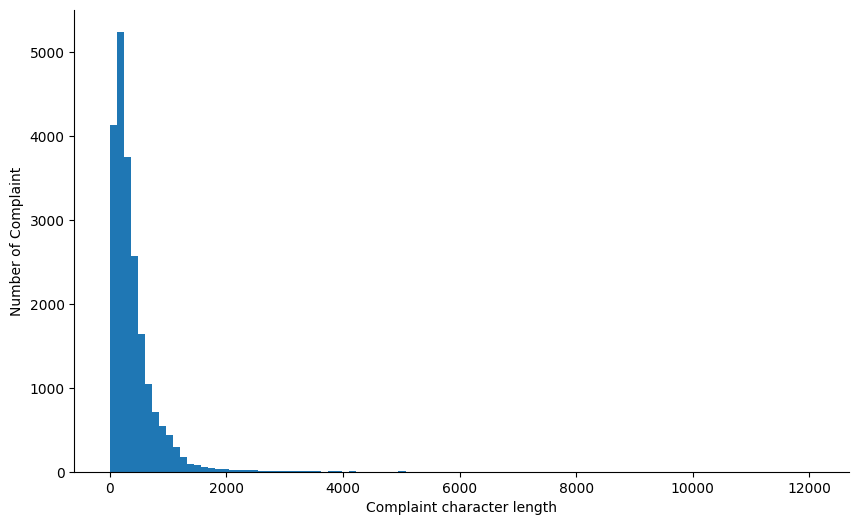

In [ ]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.complaint_POS_removed]
plt.hist(doc_lens, bins = 100)
plt.ylabel('Number of Complaint')
plt.xlabel('Complaint character length')
sns.despine();

#### Find the top 40 words by frequency among all the articles after processing the text.

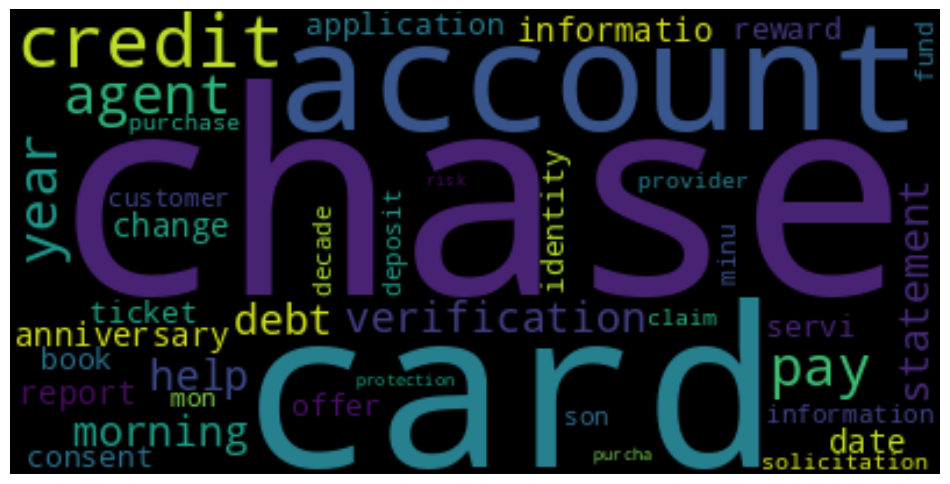

In [ ]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(max_words=40, random_state=1, stopwords=set(STOPWORDS))
wordcloud.generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [ ]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
# function to get the specified top n-grams
def get_top_n_words(corpus, n=None,count=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:count]

In [ ]:
#Print the top 10 words in the unigram frequency
unigram = get_top_n_words(df_clean['Complaint_clean'], 1,10)
for word, freq in unigram:
    print(word, freq)

chase 56708
account 41045
credit 33391
card 29757
payment 20893
charge 16099
time 15285
bank 12326
call 11917
money 11539


In [ ]:
#Print the top 10 words in the bigram frequency
bigram = get_top_n_words(df_clean['Complaint_clean'], 2,10)
for word, freq in bigram:
    print(word, freq)

credit card 12658
credit report 3826
chase credit 3061
customer service 2946
call chase 2893
account chase 2604
chase bank 2596
chase account 2283
contact chase 1973
debit card 1898


In [ ]:
#Print the top 10 words in the trigram frequency
trigram = get_top_n_words(df_clean['Complaint_clean'], 3,10)
for word, freq in trigram:
    print(word, freq)

chase credit card 2166
credit card account 1030
credit card company 978
credit card chase 813
chase customer service 602
inquiry credit report 480
charge credit card 475
credit card credit 437
credit reporting agency 378
call customer service 361


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [ ]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [ ]:
df_clean['product'] = df['product']
df_clean['sub_product'] = df['sub_product']

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [ ]:
#Write your code here to initialise the TfidfVectorizer
tf_idf_vec=TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english')


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [ ]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tfidf=tf_idf_vec.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [ ]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [ ]:
#Load your nmf_model with the n_components i.e 5

num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [ ]:
nmf_model.fit(tfidf)
len(tf_idf_vec.get_feature_names_out())

6452

In [ ]:
#Print the Top15 words for each of the topics
for index, topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index} with tf-idf score')
    print([tf_idf_vec.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')


THE TOP 15 WORDS FOR TOPIC #0 with tf-idf score
['customer', 'business', 'claim', 'transaction', 'number', 'transfer', 'branch', 'day', 'fund', 'bank', 'deposit', 'chase', 'money', 'check', 'account']


THE TOP 15 WORDS FOR TOPIC #1 with tf-idf score
['reporting', 'year', 'letter', 'application', 'limit', 'debt', 'information', 'company', 'score', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


THE TOP 15 WORDS FOR TOPIC #2 with tf-idf score
['year', 'error', 'mortgage', 'date', 'credit', 'chase', 'auto', 'time', 'day', 'fee', 'statement', 'pay', 'month', 'balance', 'payment']


THE TOP 15 WORDS FOR TOPIC #3 with tf-idf score
['email', 'statement', 'time', 'fraud', 'balance', 'service', 'claim', 'merchant', 'purchase', 'transaction', 'chase', 'dispute', 'fee', 'card', 'charge']


THE TOP 15 WORDS FOR TOPIC #4 with tf-idf score
['information', 'sale', 'foreclosure', 'time', 'request', 'rate', 'document', 'letter', 'year', 'property', 'home', 'modification', 'chase', 'mortga

In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_values = nmf_model.transform(tfidf)
topic_values.argmax(axis=1)


array([4, 0, 1, ..., 3, 2, 2])

In [ ]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = topic_values.argmax(axis=1)

In [ ]:
df_clean.head()

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,product,sub_product,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help chase debt verification statement...,morning help chase debt verification statement...,Debt collection,Credit card debt,4
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,agent anniversary date change agent informatio...,agent anniversary date change agent informatio...,Credit card or prepaid card,General-purpose credit card or charge card,0
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,card report application identity consent servi...,card report application identity consent servi...,"Credit reporting, credit repair services, or o...",Other personal consumer report,1
11,on while trying to book a xxxx xxxx ticket i c...,try book xxxx xxxx ticket come offer apply tic...,book offer ticket reward card information minu...,book offer ticket reward card information minu...,"Credit reporting, credit repair services, or o...",Credit reporting,1
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account fund account pay mon...,son deposit chase account fund account pay mon...,Checking or savings account,Checking account,0


In [ ]:
#Print the first 5 Complaint for each of the Topics
#df_clean=df_clean.groupby('Topic').head(5)
#df_clean.sort_values('Topic')

df_clean.groupby('Topic').head(5).sort_values(by='Topic')

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,product,sub_product,Topic
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,agent anniversary date change agent informatio...,agent anniversary date change agent informatio...,Credit card or prepaid card,General-purpose credit card or charge card,0
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account fund account pay mon...,son deposit chase account fund account pay mon...,Checking or savings account,Checking account,0
17,with out notice jp morgan chase restricted my ...,notice jp morgan chase restrict account debit ...,account debit card branch customer service rep...,account debit card branch customer service rep...,Checking or savings account,Checking account,0
24,mishandling of this account by chase auto and ...,mishandle account chase auto xxxx,account chase auto xxxx,account chase auto,Vehicle loan or lease,Loan,0
27,i opened an account with chase bank on xxxx an...,open account chase bank xxxx code xxxx bonus c...,account bonus call xxxxxxxx term account depos...,account bonus call term account deposit bonus...,Checking or savings account,Checking account,0
11,on while trying to book a xxxx xxxx ticket i c...,try book xxxx xxxx ticket come offer apply tic...,book offer ticket reward card information minu...,book offer ticket reward card information minu...,"Credit reporting, credit repair services, or o...",Credit reporting,1
15,can you please remove inquiry,remove inquiry,inquiry,inquiry,"Credit reporting, credit repair services, or o...",Credit reporting,1
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,card report application identity consent servi...,card report application identity consent servi...,"Credit reporting, credit repair services, or o...",Other personal consumer report,1
26,i have reached out to xxxx several times in at...,reach xxxx time attempt fraudulent inquiry rem...,time attempt inquiry remove contact creditor i...,time attempt inquiry remove contact creditor i...,"Credit reporting, credit repair services, or o...",Credit reporting,1
23,i have a chase credit card which is incorrectl...,chase credit card incorrectly report datum cre...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,Credit card or prepaid card,General-purpose credit card or charge card,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Others',
    3: 'Theft/Dispute Reporting',
    4: 'Mortgage/Loan'
}
#Replace Topics with Topic Names
df_clean['Topic_Name'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,product,sub_product,Topic,Topic_Name
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help chase debt verification statement...,morning help chase debt verification statement...,Debt collection,Credit card debt,4,Mortgage/Loan
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,agent anniversary date change agent informatio...,agent anniversary date change agent informatio...,Credit card or prepaid card,General-purpose credit card or charge card,0,Bank Account services
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,card report application identity consent servi...,card report application identity consent servi...,"Credit reporting, credit repair services, or o...",Other personal consumer report,1,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket i c...,try book xxxx xxxx ticket come offer apply tic...,book offer ticket reward card information minu...,book offer ticket reward card information minu...,"Credit reporting, credit repair services, or o...",Credit reporting,1,Credit card or prepaid card
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account fund account pay mon...,son deposit chase account fund account pay mon...,Checking or savings account,Checking account,0,Bank Account services
...,...,...,...,...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,Credit card or prepaid card,General-purpose credit card or charge card,1,Credit card or prepaid card
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx call chas xxxx xxxx visa cr...,card provider claim purchase protection purcha...,card provider claim purchase protection purcha...,Credit card or prepaid card,General-purpose credit card or charge card,3,Theft/Dispute Reporting
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer believe chase year trust mob...,pay risk consumer believe chase year trust mob...,Checking or savings account,Checking account,3,Theft/Dispute Reporting
78311,i have had flawless credit for yrs ive had cha...,flawless credit yrs ve chase credit card chase...,credit credit card chase freedom problem balan...,credit credit card chase freedom problem balan...,Credit card or prepaid card,General-purpose credit card or charge card,2,Others


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data

#Topic_names = {'Bank Account services':0, 'Credit card or prepaid card':1, 'Others':2, 'Theft/Dispute Reporting':3, 'Mortgage/Loan':4}
# Replace Topics with Topic Names
#df_clean['Topic'] = df_clean['Topic'].map(Topic_names)
training_data = df_clean[['complaints','Topic']]

In [ ]:
training_data

,complaints,Topic
1,good morning my name is xxxx xxxx and i apprec...,4
2,i upgraded my xxxx xxxx card in and was told b...,0
10,chase card was reported on however fraudulent ...,1
11,on while trying to book a xxxx xxxx ticket i c...,1
14,my grand son give me check for i deposit it in...,0
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,3
78310,i am not familiar with xxxx pay and did not un...,3
78311,i have had flawless credit for yrs ive had cha...,2


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
#Write your code to get the Vector count

count_vect=CountVectorizer()
X_train_counts=count_vect.fit_transform(training_data['complaints'])
#Write your code here to transform the word vector to tf-idf
tfidf_transformer=TfidfTransformer()
X_train_tf=tfidf_transformer.fit_transform(X_train_counts)

In [ ]:
px.bar(x=training_data['Topic'].value_counts().index, y=training_data['Topic'].value_counts().values/max(training_data['Topic'].value_counts().values), title='Class Imbalance')


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# importing libraries required for model building and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold,GridSearchCV,train_test_split

from sklearn.metrics import roc_auc_score,accuracy_score,precision_score,recall_score,f1_score,classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [ ]:
# Prepare the training and test data
train_X, test_X, train_y, test_y = train_test_split(X_train_tf, training_data['Topic'], test_size=0.2, random_state=40)

In [ ]:
# function to evaluate the model and display the results
def eval_model(y_test,y_pred,y_pred_proba,type='Training'):
    print(type,'results')
    print('Accuracy: ', round(accuracy_score(y_test, y_pred), 2))
    print('Precision: ', round(precision_score(y_test, y_pred, average='weighted'), 2))
    print('Recall: ', round(recall_score(y_test, y_pred, average='weighted'), 2))
    print('F1 Score: ', round(f1_score(y_test, y_pred, average='weighted'), 2))
    print('ROC AUC Score: ', round(roc_auc_score(y_test, y_pred_proba, average='weighted', multi_class='ovr'), 2))
    print('Classification Report: ', classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test,y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=training_data['Topic'].unique())
    disp.plot()

In [ ]:
# function to grid search the best parameters for the model
def run_model(model,param_grid):
    cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=40)
    grid=GridSearchCV(model,param_grid={},cv=cv,scoring='f1_weighted',verbose=1,n_jobs=-1)
    grid.fit(train_X,train_y)
    return grid.best_estimator_

Logistic Regression

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Training results
Accuracy:  0.96
Precision:  0.96
Recall:  0.96
F1 Score:  0.96
ROC AUC Score:  1.0
Classification Report:                precision    recall  f1-score   support

           0       0.95      0.97      0.96      4037
           1       0.96      0.97      0.97      3953
           2       0.98      0.92      0.95      1821
           3       0.96      0.96      0.96      3704
           4       0.96      0.96      0.96      3342

    accuracy                           0.96     16857
   macro avg       0.96      0.96      0.96     16857
weighted avg       0.96      0.96      0.96     16857

Test results
Accuracy:  0.91
Precision:  0.91
Recall:  0.91
F1 Score:  0.91
ROC AUC Score:  0.99
Classification Report:                precision    recall  f1-score   support

           0       0.92      0.93      0.92      1023
           1       0.90      0.92      0.91       968
           2       0.93      0.86      0.89 

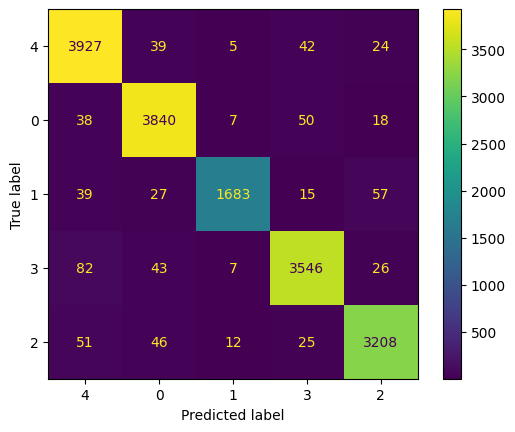

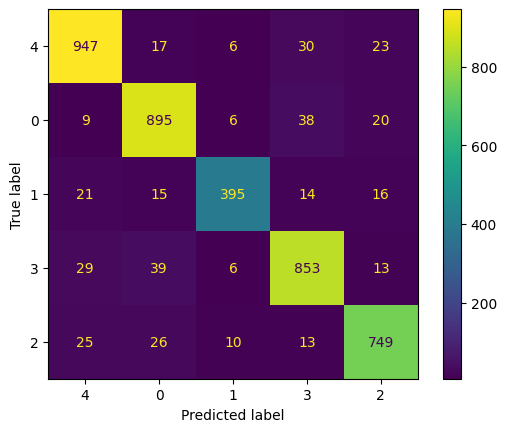

In [ ]:
#running and evaluating the Logistic Regression model
params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300, 500, 1000],
    'class_weight': [None, 'balanced']
}
model=run_model(LogisticRegression(),params)
eval_model(train_y,model.predict(train_X),model.predict_proba(train_X),type='Training')
eval_model(test_y,model.predict(test_X),model.predict_proba(test_X),type='Test')

2. Decision Tree

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Training results
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0
ROC AUC Score:  1.0
Classification Report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00      4037
           1       1.00      1.00      1.00      3953
           2       1.00      1.00      1.00      1821
           3       1.00      1.00      1.00      3704
           4       1.00      1.00      1.00      3342

    accuracy                           1.00     16857
   macro avg       1.00      1.00      1.00     16857
weighted avg       1.00      1.00      1.00     16857

Test results
Accuracy:  0.78
Precision:  0.78
Recall:  0.78
F1 Score:  0.78
ROC AUC Score:  0.86
Classification Report:                precision    recall  f1-score   support

           0       0.79      0.78      0.78      1023
           1       0.79      0.81      0.80       968
           2       0.75      0.75      0.75     

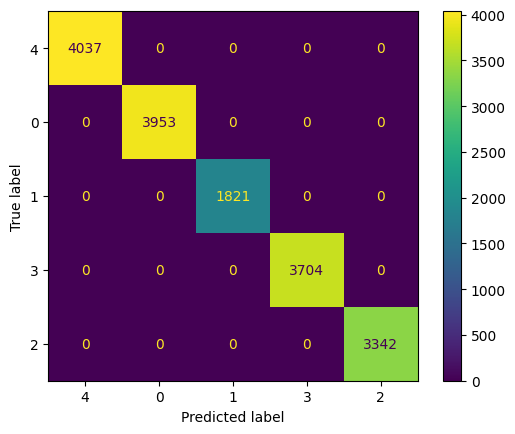

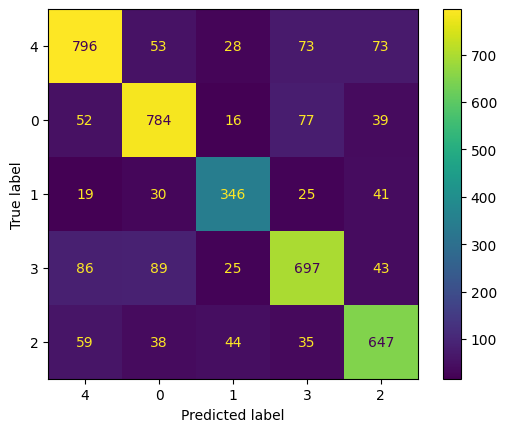

In [ ]:
#running and evaluating the Decision Tree model
params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 2, 4, 6, 8, 10],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}
model=run_model(DecisionTreeClassifier(),params)
eval_model(train_y,model.predict(train_X),model.predict_proba(train_X),type='Training')
eval_model(test_y,model.predict(test_X),model.predict_proba(test_X),type='Test')

3. Random Forest

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Training results
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0
ROC AUC Score:  1.0
Classification Report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00      4037
           1       1.00      1.00      1.00      3953
           2       1.00      1.00      1.00      1821
           3       1.00      1.00      1.00      3704
           4       1.00      1.00      1.00      3342

    accuracy                           1.00     16857
   macro avg       1.00      1.00      1.00     16857
weighted avg       1.00      1.00      1.00     16857

Test results
Accuracy:  0.82
Precision:  0.83
Recall:  0.82
F1 Score:  0.81
ROC AUC Score:  0.97
Classification Report:                precision    recall  f1-score   support

           0       0.78      0.91      0.84      1023
           1       0.79      0.87      0.82       968
           2       0.92      0.44      0.60     

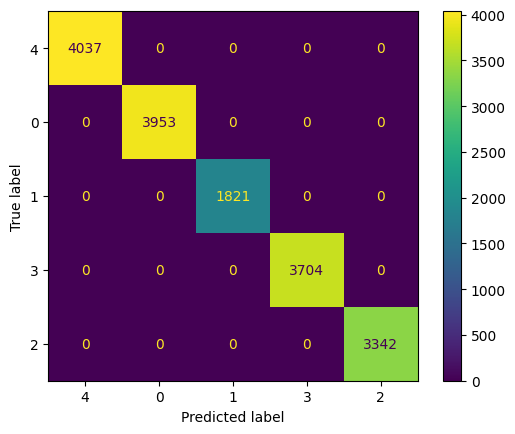

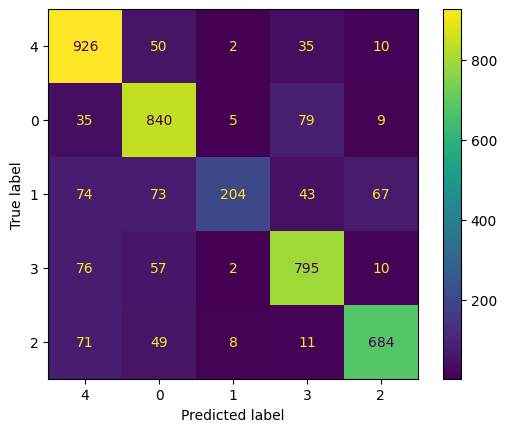

In [ ]:
#running and evaluating the Random Forest model
params = {
    'n_estimators': [10, 50, 100, 200, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 4, 6, 8, 10],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}
model=run_model(RandomForestClassifier(),params)
eval_model(train_y,model.predict(train_X),model.predict_proba(train_X),type='Training')
eval_model(test_y,model.predict(test_X),model.predict_proba(test_X),type='Test')

Multinomial Naive Bias

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Training results
Accuracy:  0.75
Precision:  0.79
Recall:  0.75
F1 Score:  0.71
ROC AUC Score:  0.96
Classification Report:                precision    recall  f1-score   support

           0       0.69      0.93      0.80      4037
           1       0.74      0.81      0.78      3953
           2       1.00      0.02      0.04      1821
           3       0.79      0.83      0.81      3704
           4       0.82      0.78      0.80      3342

    accuracy                           0.75     16857
   macro avg       0.81      0.68      0.65     16857
weighted avg       0.79      0.75      0.71     16857

Test results
Accuracy:  0.73
Precision:  0.74
Recall:  0.73
F1 Score:  0.69
ROC AUC Score:  0.94
Classification Report:                precision    recall  f1-score   support

           0       0.66      0.91      0.77      1023
           1       0.70      0.78      0.74       968
           2       0.83      0.01      0.02

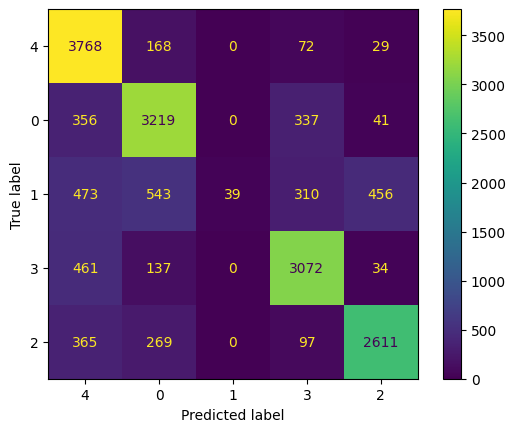

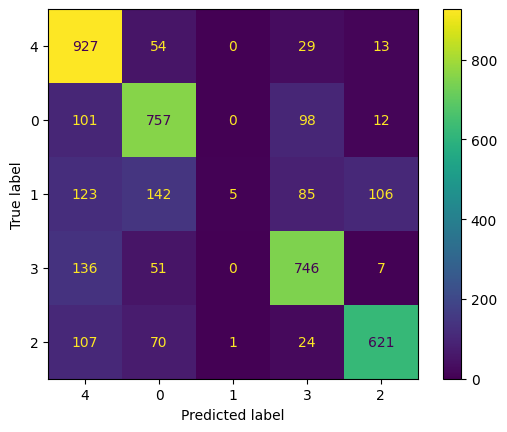

In [ ]:
#running and evaluating the Gaussian Naive Bayes model
params = {
    'alpha': [0.1, 0.5, 1, 2, 5],
    'fit_prior': [True, False]
}
model=run_model(MultinomialNB(),params)
eval_model(train_y,model.predict(train_X),model.predict_proba(train_X),type='Training')
eval_model(test_y,model.predict(test_X),model.predict_proba(test_X),type='Test')

XGBoost Classifier

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Training results
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0
ROC AUC Score:  1.0
Classification Report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00      4037
           1       1.00      1.00      1.00      3953
           2       1.00      1.00      1.00      1821
           3       1.00      1.00      1.00      3704
           4       1.00      1.00      1.00      3342

    accuracy                           1.00     16857
   macro avg       1.00      1.00      1.00     16857
weighted avg       1.00      1.00      1.00     16857

Test results
Accuracy:  0.91
Precision:  0.91
Recall:  0.91
F1 Score:  0.91
ROC AUC Score:  0.99
Classification Report:                precision    recall  f1-score   support

           0       0.92      0.92      0.92      1023
           1       0.91      0.93      0.92       968
           2       0.90      0.92      0.91     

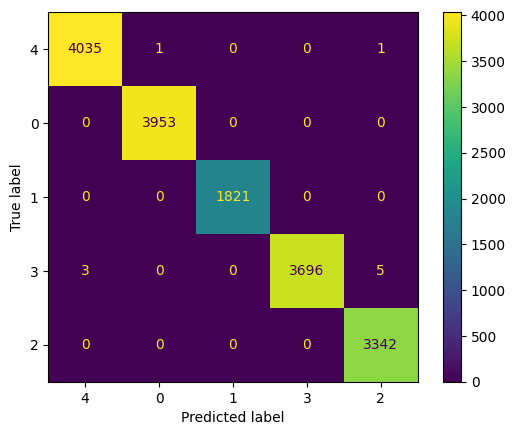

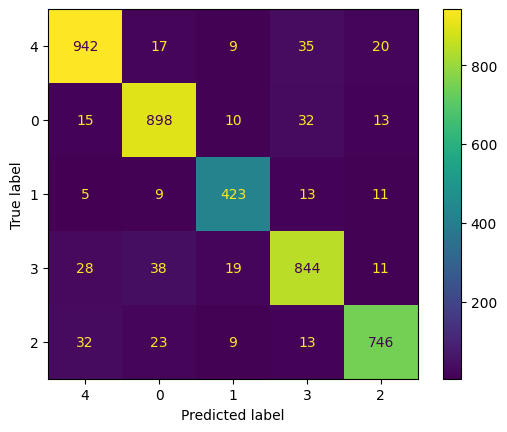

In [ ]:
#running and evaluating the XGBoost model
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}
model=run_model(XGBClassifier(), params)
eval_model(train_y,model.predict(train_X),model.predict_proba(train_X),type='Training')
eval_model(test_y,model.predict(test_X),model.predict_proba(test_X),type='Test')

Conclusions

As from the results we can see that Logistic Regression and XGBoost Classifier are performing the best with an F1 score of more than 0.91. So we will be using these models to predict the topics for the new complaints.
